<h1><center>Text Classification</center></h1>

In [2]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import stanza

#from preprocess import * 
from custom_preprocessing import CustomPreProcessing
from custom_preprocessing import PreProcessing
from class_metric import Metrics

import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils
from sklearn.metrics import make_scorer

import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

Using TensorFlow backend.
0it [00:00, ?it/s]


In [3]:
sklearn.__version__

'0.23.0'

---

<center><h2>Parameters</h2></center>

---

This part allows you to determine the text column to classify as well as the label column.

In [4]:
TEXT = "mails"
LABEL = "label"

In [5]:
# ---- Create object to preprocess the text 
preprocess = CustomPreProcessing()
preproc = PreProcessing()
Metric = Metrics()

Welcome in this custom preprocessing class
        
Welcome in the preprocessing


---

<center><h2>List of Models</h2></center>

---

In [6]:
lang                   = False
sample                 = True
part_of_speech         = False
sgd                    = True
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_learning          = True
pre_trained            = False
transformers_models    = False   # work in progress 
ulmfit_model           = False   # work in progress 
multifit_model         = False   # work in progress
rbm_models             = False   # work in progress 
reinforcement_learning = False   # work in progress 

---

---

<center><i><h1>Sand Box to Load Data</h1></i></center>

---

The sandbox is the working area of your data if it has not been processed before using the pipe

In [173]:
df = pd.read_csv("mails_clean_new.csv", sep=";")

In [174]:
df[LABEL][df[LABEL]!="annulation"] = "other"

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [175]:
df[LABEL].value_counts()

other         11585
annulation     9483
Name: label, dtype: int64

In [176]:
df[TEXT].isnull().sum()

441

In [177]:
df[TEXT][df[TEXT].isnull()] = "empty"

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


---

<center><i><h1>Sart Pipeline</h1></i></center>

---

In [12]:
if lang:
    # ---- Language detection of the text
    df.loc[:,"language"] = df[TEXT].progress_apply(preproc.func_detect_lang_google)
    # ---- Extract most frequent language 
    language = df.language.value_counts().index.tolist()[0]
    print(f"The language most present in the dataset is {language}")

In [13]:
language="fr"

---

---

<center><h3>Prepare data for ML Classic</h3></center>

---

In [180]:
if sample:
    df_save = df.copy()
    df = df.sample(5000, random_state=42)

In [179]:
#df = df_save.copy()

In [15]:
# ---- Load stopwords 
if language=="fr":
    stop_word = np.loadtxt("stopwords-fr/stopwords-fr.txt", dtype=str)
if language=="en":
    stop_word = np.loadtxt("stopwords_en.txt", dtype=str)

In [181]:
df.loc[:,TEXT+"_sw"] = df.loc[:,TEXT].progress_apply(lambda x : preproc.func_remove_stop_words(x, stop_word))

100%|██████████| 5000/5000 [00:15<00:00, 327.62it/s]


---

---

<h1><center>Machine Learning</center></h1>

---

---

In [182]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(df[TEXT+"_sw"], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df[TEXT], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<center><h3>Classes Weight</h3></center>

---

In [18]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [19]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 1.105	class: annulation
Class weight: 0.9132	class: other


In [20]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.825)


---

<h2>Save Unique Labels</h2>

---

In [183]:
# Keep the unique label corresponding to their encoding correspondance
labels = df[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()

---

<h3>One-Hot encoding (CountVectorizing)</h3>

---

In [184]:
%%time
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT]+"_sw")

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: user 1.58 s, sys: 46.9 ms, total: 1.62 s
Wall time: 1.62 s


In [270]:
#xtrain_tfidf.toarray()[0][xtrain_tfidf.toarray()[0]  >0]

---

<h3>TF-IDF</h3>

---

In [271]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(df[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=10000)
tfidf_vect_ngram.fit(df[TEXT])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=10000) #token_pattern=r'\w{1,}',
tfidf_vect_ngram_chars.fit(df[TEXT])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 18.8 s, sys: 469 ms, total: 19.3 s
Wall time: 19.3 s


---

<h2>Load Pre-Trained model fastText</h2>

---

In [24]:
%%time
if language=="fr":
    pretrained = fasttext.FastText.load_model('fastText/cc.fr.300.bin')
if language=="en":
    pretrained = fasttext.FastText.load_model('fastText/crawl-300d-2M-subword.bin')
    

CPU times: user 4.86 s, sys: 10 s, total: 14.9 s
Wall time: 15.1 s


---

<h2>Word Embeddings</h2>

---

In [257]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
words = []
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    words.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

100%|██████████| 59891/59891 [00:03<00:00, 19468.63it/s]

CPU times: user 1.98 s, sys: 438 ms, total: 2.42 s
Wall time: 3.08 s


In [259]:
words[1], embedding_matrix[1]

('la',
 array([-8.41776654e-02, -3.87750976e-02,  4.56315391e-02, -5.58942221e-02,
        -3.65605094e-02,  2.40599122e-02,  9.18988436e-02, -2.14237850e-02,
         1.78663842e-02, -1.38375148e-01, -2.02065557e-02, -1.27626970e-01,
        -1.62504520e-02,  6.43651411e-02, -1.04147069e-01,  1.51698468e-02,
        -1.90562047e-02,  7.61077702e-02, -1.49265630e-02,  2.60680299e-02,
         3.53557691e-02, -7.69628063e-02, -3.35048977e-03,  9.40520838e-02,
        -1.69285238e-02,  1.62121311e-01,  2.46886551e-01, -8.96195974e-03,
         3.34579013e-02,  2.15324527e-03, -1.68294888e-02, -6.34551793e-03,
         1.48613639e-02, -1.82319749e-02,  2.05345936e-02,  6.27564117e-02,
        -3.59112889e-01, -1.54590895e-02,  1.87979192e-02,  5.03448397e-02,
        -2.51461528e-02,  3.28096338e-02,  3.99812646e-02,  6.38690144e-02,
        -1.50217474e-01,  1.65500298e-01,  5.38009182e-02,  7.61706382e-02,
        -1.08563438e-01, -3.51008028e-02,  5.34282103e-02,  2.67316885e-02,
     

In [26]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [187]:
def report(clf, x, y, name='classifier', cv=5, fit_params=None):
    
    scoring = {'acc': 'accuracy',
           'balanced_accuracy':'balanced_accuracy',
           'prec': 'precision_weighted',
           'recall': 'recall_weighted',
           'f1-score':'f1_weighted',
           'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn),
            'cohens_kappa':make_scorer(cohen_kappa_score),
            'matthews_corrcoef':make_scorer(matthews_corrcoef),
              "roc_auc":"roc_auc"}
    #if clf==XGBClassifier():
    scores = cross_validate(clf, x, y, scoring=scoring,
                         cv=cv, return_train_score=True, n_jobs=-1,  fit_params=fit_params)
    
    index = []
    value = []
    index.append("Model")
    value.append(name)
    for i in scores:
        if i == "estimator":
            continue
        for j in enumerate(scores[i]):
            index.append(i+"_cv"+str(j[0]+1))
            value.append(j[1])
        #if any(x in i for x in scoring.keys()):
        
        index.append(i+"_mean")
        value.append(np.mean(scores[i]))
        index.append(i+"_std")
        value.append(np.std(scores[i]))
        
    return pd.DataFrame(data=value, index=index).T

In [149]:
report(naive_bayes.MultinomialNB(), xtrain_count,train_y_sw, name='NB_Count_Vectors', cv=5)[["test_matthews_corrcoef_mean", "test_matthews_corrcoef_std"]]

,test_matthews_corrcoef_mean,test_matthews_corrcoef_std
0,0.632611,0.0493682


---

<center><h2>Multinomial Naive Bayes</h2></center>

---

In [272]:
df_results = pd.DataFrame()

In [273]:
%%time
df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_count,train_y_sw, name='NB_Count_Vectors', cv=5))
df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf,train_y_sw, name='NB_WordLevel_TF-IDF', cv=5))
df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram,train_y_sw, name='NB_N-Gram_Vectors', cv=5))
df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars,train_y_sw, name='NB_CharLevel_Vectors', cv=5))

CPU times: user 125 ms, sys: 4.62 s, total: 4.75 s
Wall time: 9.44 s


---

<center><h2>Logistic Regression</h2></center>

---

In [274]:
%%time
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_count,train_y_sw, name='LR_Count_Vectors', cv=5))
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf,train_y_sw, name='LR_WordLevel_TF-IDF', cv=5))
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram,train_y_sw, name='LR_N-Gram_Vectors', cv=5))
df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram_chars,train_y_sw, name='LR_CharLevel_Vectors', cv=5))

CPU times: user 203 ms, sys: 93.8 ms, total: 297 ms
Wall time: 6.46 s


---

<center><h2>SVM</h2></center>

---

In [275]:
%%time
df_results = df_results.append(report(svm.SVC(), xtrain_count,train_y_sw, name='SVM_Count_Vectors', cv=5))
df_results = df_results.append(report(svm.SVC(), xtrain_tfidf,train_y_sw, name='SVM_WordLevel_TF-IDF', cv=5))
df_results = df_results.append(report(svm.SVC(), xtrain_tfidf_ngram,train_y_sw, name='SVM_N-Gram_Vectors', cv=5))
df_results = df_results.append(report(svm.SVC(), xtrain_tfidf_ngram_chars,train_y_sw, name='SVM_CharLevel_Vectors', cv=5))

CPU times: user 172 ms, sys: 78.1 ms, total: 250 ms
Wall time: 5min 32s


---

<center><h2>RandomForest</h2></center>

---

In [276]:
%%time
df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_count,train_y_sw, name='RF_Count_Vectors', cv=5))

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 32.6 s


In [277]:
%%time
df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf,train_y_sw, name='RF_WordLevel_TF-IDF', cv=5))

CPU times: user 46.9 ms, sys: 953 ms, total: 1 s
Wall time: 11.9 s


In [278]:
%%time
df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf_ngram,train_y_sw, name='RF_N-Gram_Vectors', cv=5))

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 9.68 s


In [279]:
%%time
df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf_ngram_chars,train_y_sw, name='RF_CharLevel_Vectors', cv=5))

CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 25.9 s


In [280]:
%%time
df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), train_seq_x,train_y, name='RF_Words', cv=5))

CPU times: user 46.9 ms, sys: 906 ms, total: 953 ms
Wall time: 6.43 s


---

<center><h2>Stochastic Descent</h2></center>

---

In [281]:
%%time
df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_count,train_y_sw, name='SGD_Count_Vectors', cv=5))
df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf,train_y_sw, name='SGD_WordLevel_TF-IDF', cv=5))
df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram,train_y_sw, name='SGD_N-Gram_Vectors', cv=5))
df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram_chars,train_y_sw, name='SGD_CharLevel_Vectors', cv=5))
df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), train_seq_x,train_y, name='SGD_Words', cv=5))

CPU times: user 266 ms, sys: 62.5 ms, total: 328 ms
Wall time: 2.09 s


---

<center><h2>Gradient Boosting</h2></center>

---

In [282]:
%%time
df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_count,train_y_sw, name='GB_Count_Vectors', cv=5))

CPU times: user 31.2 ms, sys: 31.2 ms, total: 62.5 ms
Wall time: 26.3 s


In [283]:
%%time
df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf,train_y_sw, name='GB_WordLevel_TF-IDF', cv=5))

CPU times: user 46.9 ms, sys: 46.9 ms, total: 93.8 ms
Wall time: 13.1 s


In [284]:
%%time
df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf_ngram,train_y_sw, name='GB_N-Gram_Vectors', cv=5))

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 6.73 s


In [285]:
%%time
df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf_ngram_chars,train_y_sw, name='GB_CharLevel_Vectors', cv=5))

CPU times: user 46.9 ms, sys: 31.2 ms, total: 78.1 ms
Wall time: 1min 31s


In [286]:
%%time
df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), train_seq_x,train_y, name='GB_CharLevel_Vectors', cv=5))

CPU times: user 0 ns, sys: 62.5 ms, total: 62.5 ms
Wall time: 11.6 s


---

<h2>XGBoost Classifier</h2>

---

All the XGBoost have early stopping implemented with 10 rounds

In [287]:
%%time
fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_count, valid_y_sw)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_count,train_y_sw, name='XGB_Count_Vectors', cv=5, fit_params=fit_params))


CPU times: user 62.5 ms, sys: 31.2 ms, total: 93.8 ms
Wall time: 17.6 s


In [288]:
%%time
fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf, valid_y_sw)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf,train_y_sw, name='XGB_WordLevel_TF-IDF', cv=5, fit_params=fit_params))

CPU times: user 46.9 ms, sys: 62.5 ms, total: 109 ms
Wall time: 9.5 s


In [289]:
%%time
fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf_ngram, valid_y_sw)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf_ngram,train_y_sw, name='XGB_N-Gram_Vectors', cv=5, fit_params=fit_params))

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 6.59 s


In [290]:
%%time
fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf_ngram_chars, valid_y_sw)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf_ngram_chars,train_y_sw, name='XGB_CharLevel_Vectors', cv=5, fit_params=fit_params))

CPU times: user 93.8 ms, sys: 62.5 ms, total: 156 ms
Wall time: 48.9 s


In [291]:
%%time
fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(valid_seq_x,valid_y)]}
df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), train_seq_x,train_y, name='XGB_Words', cv=5, fit_params=fit_params))

CPU times: user 15.6 ms, sys: 46.9 ms, total: 62.5 ms
Wall time: 7.33 s


In [292]:
df_results.reset_index(inplace=True)

In [293]:
df_results.shape

(32, 184)

In [294]:
df_results[["Model",  "train_acc_mean", "train_acc_std","test_acc_mean","test_acc_std", 
                    "train_balanced_accuracy_mean", "train_balanced_accuracy_std","test_balanced_accuracy_mean","test_balanced_accuracy_std", 
                    "train_prec_mean","train_prec_std",
                   "test_prec_mean", "test_prec_std", "train_recall_mean","train_recall_std", "test_recall_mean","test_recall_std", "train_f1-score_mean",
                   "train_f1-score_std","test_f1-score_mean", "test_f1-score_std", "train_cohens_kappa_mean", "train_cohens_kappa_std",
                   "test_cohens_kappa_mean", "test_cohens_kappa_std", "test_matthews_corrcoef_mean","test_matthews_corrcoef_std", 
                   "test_roc_auc_mean", "test_roc_auc_std"]].sort_values(
                    by=["test_balanced_accuracy_mean","test_recall_mean" ], ascending=False)

,Model,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,train_balanced_accuracy_mean,train_balanced_accuracy_std,test_balanced_accuracy_mean,test_balanced_accuracy_std,train_prec_mean,...,test_f1-score_mean,test_f1-score_std,train_cohens_kappa_mean,train_cohens_kappa_std,test_cohens_kappa_mean,test_cohens_kappa_std,test_matthews_corrcoef_mean,test_matthews_corrcoef_std,test_roc_auc_mean,test_roc_auc_std
4,LR_Count_Vectors,0.983437,0.000655506,0.88575,0.00322102,0.982341,0.000679743,0.882937,0.00398088,0.983647,...,0.885453,0.00336135,0.966557,0.00132394,0.76885,0.00682268,0.769805,0.00617491,0.947696,0.00480619
11,SVM_CharLevel_Vectors,0.941188,0.00222205,0.8845,0.00896521,0.940942,0.00221798,0.882091,0.00929454,0.941227,...,0.884272,0.00902697,0.881526,0.00447256,0.766515,0.0182777,0.767157,0.0182029,0.940424,0.00582579
18,SGD_WordLevel_TF-IDF,0.971813,0.0013317,0.88225,0.0055,0.97076,0.00161628,0.878963,0.00486861,0.972006,...,0.881869,0.00538294,0.943099,0.00271114,0.76158,0.0107993,0.76296,0.0114879,0.945943,0.00685369
9,SVM_WordLevel_TF-IDF,0.958125,0.00142522,0.881,0.00823104,0.957631,0.00138076,0.87734,0.00897222,0.958127,...,0.880526,0.00840205,0.915582,0.00286342,0.758835,0.0170011,0.760562,0.0163147,0.940521,0.00686465
28,XGB_WordLevel_TF-IDF,0.94825,0.016915,0.87975,0.00566789,0.94527,0.0176866,0.875215,0.00600984,0.949621,...,0.879096,0.00577157,0.895124,0.0344589,0.755892,0.0116707,0.7586,0.0113068,0.944262,0.00885265
5,LR_WordLevel_TF-IDF,0.914563,0.00284083,0.87525,0.00826892,0.9119,0.00289232,0.870999,0.00879142,0.915106,...,0.87463,0.00840089,0.827126,0.00576078,0.746912,0.0169841,0.749321,0.0165667,0.946383,0.00570888
27,XGB_Count_Vectors,0.935125,0.01801,0.87275,0.0055,0.931396,0.0190002,0.868302,0.00557383,0.93722,...,0.872091,0.00554341,0.868346,0.0367572,0.741763,0.0111542,0.744281,0.0111091,0.942822,0.0043094
20,SGD_CharLevel_Vectors,0.951,0.00491093,0.86675,0.00857321,0.951818,0.00444062,0.866706,0.00925451,0.951775,...,0.866687,0.0086576,0.901499,0.00977199,0.731976,0.0174136,0.73403,0.0169647,0.936875,0.00394721
13,RF_WordLevel_TF-IDF,0.988375,0.00060596,0.8675,0.00876784,0.987574,0.000556712,0.863866,0.00917903,0.988492,...,0.867009,0.00885533,0.976539,0.00121966,0.731558,0.0179452,0.733099,0.0178345,0.938236,0.00466946
17,SGD_Count_Vectors,0.948813,0.00655625,0.86375,0.00591608,0.947077,0.00748133,0.861704,0.00627508,0.949489,...,0.863509,0.00588915,0.896544,0.0134163,0.724864,0.0119577,0.726,0.0123762,0.913176,0.0103552


---

<center><h1>Deep Learning</h1></center>

---

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

---

<h3>Early Stopping, Model saving, Class weight configuration</h3>

In [62]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [63]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

---

<h2>Shallow Neural Networks</h2>

In [64]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [65]:
if deep_learning:
    model_shallow = shallow_neural_networks(word_index, pre_trained=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          2530464   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,530,481
Trainable params: 2,530,481
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
if deep_learning:
    history = model_shallow.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:22:38 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43e79a620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.5540WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43ec0f0d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:22:54 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43ec0f0d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 15s 36ms/step - loss: 0.6770 - accuracy: 0.5540 - val_loss: 0.6443 - val_accuracy: 0.6725
Epoch 2/1000
422/422 [==============================] - 13s 31ms/step - loss: 0.6374 - accuracy: 0.7191 - val_loss: 0.6115 - val_accuracy: 0.7630
Epoch 3/1000
422/422 [==============================] - 12s 27ms/step - loss: 0.6062 - accuracy: 0.8106 - val_loss: 0.5879 - val_accuracy: 0.8185
Epoch 4/1000
422/422 [==============================] - 15s 36ms/step - loss: 0.5864 - accuracy: 0.8374 - val_loss: 0.5742 - val_accuracy: 0.8303
Epoch 5/1000
422/422 [==============================] - 12s 27ms/step - loss: 0.5750 - accuracy: 0.8503 - val_loss: 0.5656 

In [67]:
if deep_learning:
    results = model_shallow.evaluate(valid_seq_x, valid_y)
    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model_shallow.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 0s 4ms/step - loss: 0.5350 - accuracy: 0.9022
[0.5350382328033447, 0.9022306799888611]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:31:05 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe439755620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 91.43%


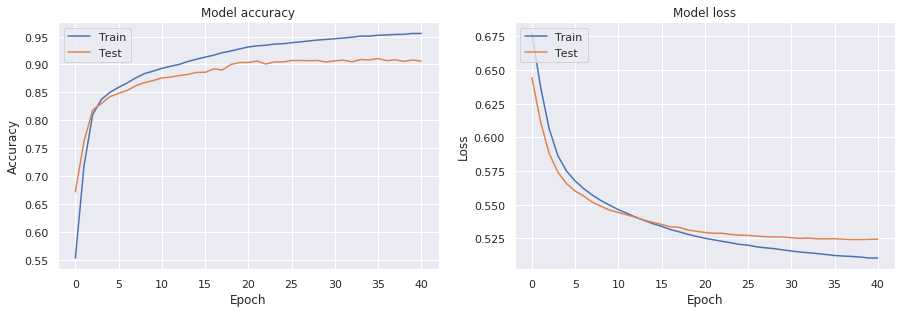

              precision    recall  f1-score   support

  annulation       0.89      0.90      0.89      1897
       other       0.91      0.91      0.91      2317

    accuracy                           0.90      4214
   macro avg       0.90      0.90      0.90      4214
weighted avg       0.90      0.90      0.90      4214


The balanced accuracy is : 90.17%


The Zero-one Loss is : 9.78%


Explained variance score: 0.605


ROC AUC=0.955 



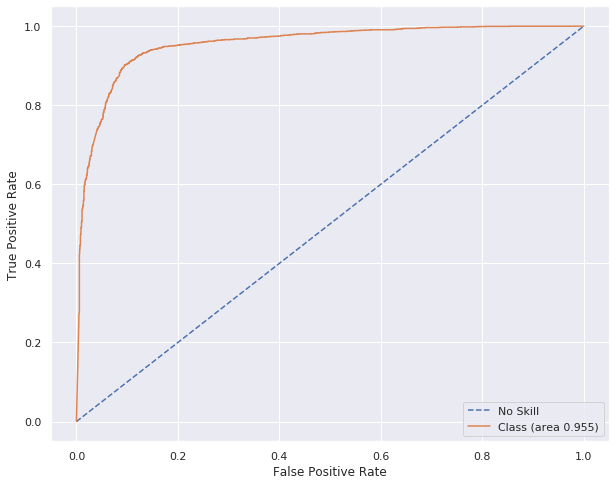



Model: f1-score=0.911 AUC=0.961




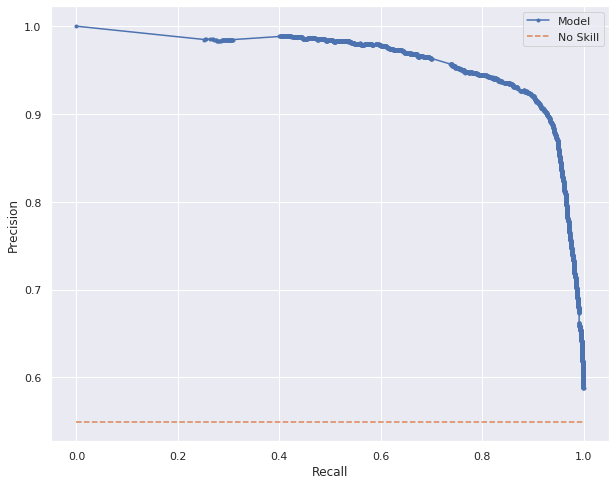


Cohen's kappa: 80.27% 

                 Predicted Negative  Predicted Positive
Actual Negative                1700                 197
Actual Positive                 215                2102

Confusion Matrix



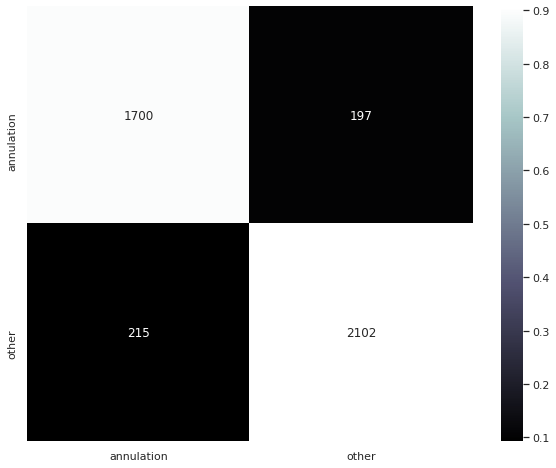

In [68]:
if deep_learning:
    Metric.func_metrics_deep_learning(model_shallow, history, valid_seq_x, valid_y, labels)

---

<h2>Deep Neural Networks</h2>

---

In [69]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [70]:
if deep_learning:
    model = deep_neural_networks(word_index, pre_trained=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          7907700   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 7,908,533
Trainable params: 7,908,533
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:31:13 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43a1c92f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.6766WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe44bb1a268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:31:46 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe44bb1a268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 33s 77ms/step - loss: 0.6369 - accuracy: 0.6766 - val_loss: 0.5676 - val_accuracy: 0.8324
Epoch 2/1000
422/422 [==============================] - 30s 71ms/step - loss: 0.5616 - accuracy: 0.8592 - val_loss: 0.5468 - val_accuracy: 0.8641
Epoch 3/1000
422/422 [==============================] - 32s 77ms/step - loss: 0.5457 - accuracy: 0.8861 - val_loss: 0.5379 - val_accuracy: 0.8778
Epoch 4/1000
422/422 [==============================] - 35s 84ms/step - loss: 0.5360 - accuracy: 0.9029 - val_loss: 0.5334 - val_accuracy: 0.8840
Epoch 5/1000
422/422 [==============================] - 32s 76ms/step - loss: 0.5294 - accuracy: 0.9164 - val_loss: 0.5306 

In [72]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 1s 4ms/step - loss: 0.5344 - accuracy: 0.9025
[0.5343595743179321, 0.9024679660797119]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:38:44 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43d7d6400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 91.65%


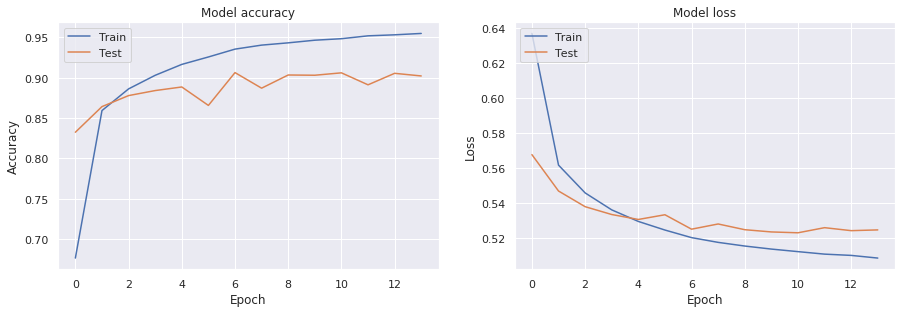

              precision    recall  f1-score   support

  annulation       0.89      0.90      0.89      1897
       other       0.92      0.91      0.91      2317

    accuracy                           0.90      4214
   macro avg       0.90      0.90      0.90      4214
weighted avg       0.90      0.90      0.90      4214


The balanced accuracy is : 90.22%


The Zero-one Loss is : 9.75%


Explained variance score: 0.606


ROC AUC=0.953 



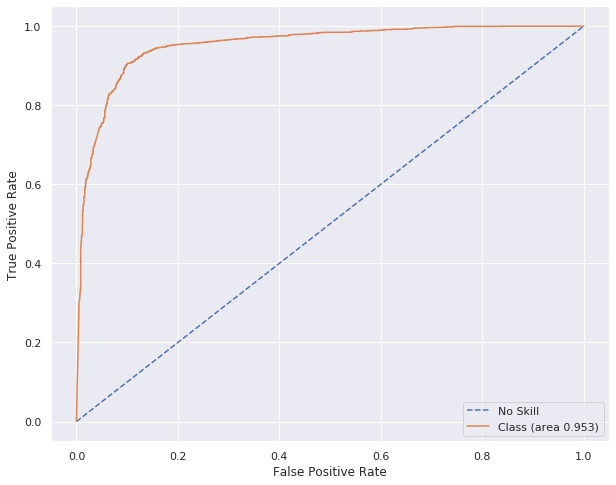



Model: f1-score=0.911 AUC=0.959




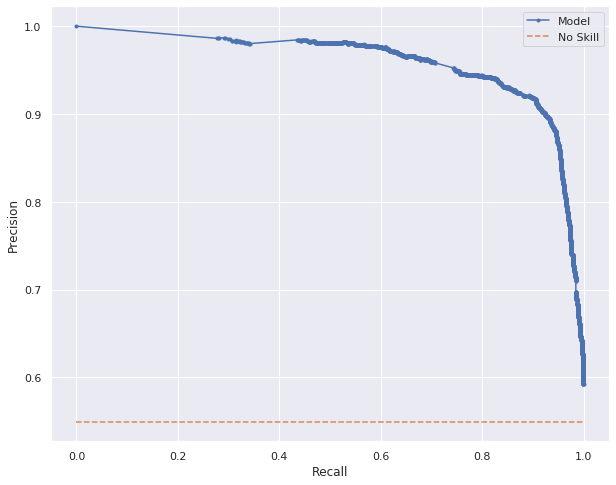


Cohen's kappa: 80.33% 

                 Predicted Negative  Predicted Positive
Actual Negative                1706                 191
Actual Positive                 220                2097

Confusion Matrix



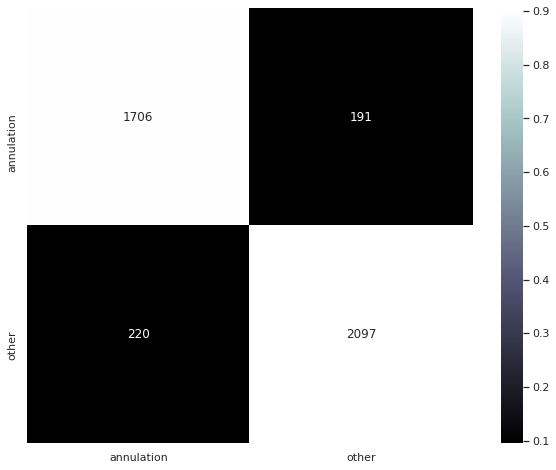

In [73]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 1</h2>

In [74]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [75]:
if deep_learning:
    model = deep_neural_networks_var1(word_index, pre_trained=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         15815400  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 15,817,305
Trainable params: 15,817,305
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:38:53 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43ac34ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.7657WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43b4ee6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 15:43:13 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43b4ee6a8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 259s 614ms/step - loss: 0.6187 - accuracy: 0.7657 - val_loss: 0.5499 - val_accuracy: 0.8552
Epoch 2/1000
422/422 [==============================] - 251s 596ms/step - loss: 0.5480 - accuracy: 0.8753 - val_loss: 0.5350 - val_accuracy: 0.8840
Epoch 3/1000
422/422 [==============================] - 291s 689ms/step - loss: 0.5332 - accuracy: 0.9042 - val_loss: 0.5310 - val_accuracy: 0.8802
Epoch 4/1000
422/422 [==============================] - 268s 634ms/step - loss: 0.5262 - accuracy: 0.9191 - val_loss: 0.5283 - val_accuracy: 0.8991
Epoch 5/1000
422/422 [==============================] - 242s 574ms/step - loss: 0.5215 - accuracy: 0.9276 - val_los

In [77]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.9032
[0.5327215194702148, 0.9031798839569092]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 16:28:24 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43bf2c620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 91.02%


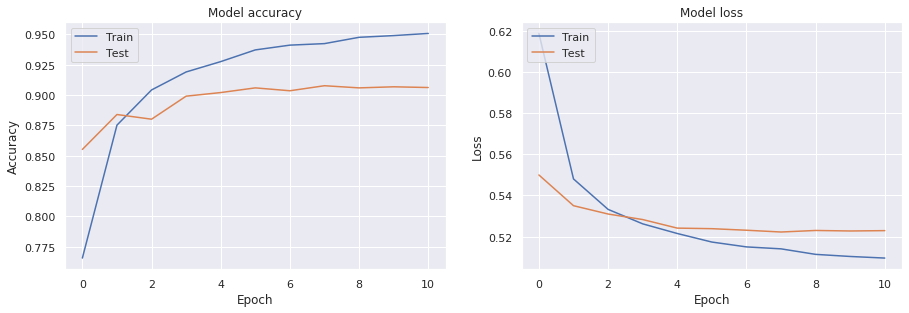

              precision    recall  f1-score   support

  annulation       0.89      0.89      0.89      1897
       other       0.91      0.91      0.91      2317

    accuracy                           0.90      4214
   macro avg       0.90      0.90      0.90      4214
weighted avg       0.90      0.90      0.90      4214


The balanced accuracy is : 90.2%


The Zero-one Loss is : 9.68%


Explained variance score: 0.609


ROC AUC=0.951 



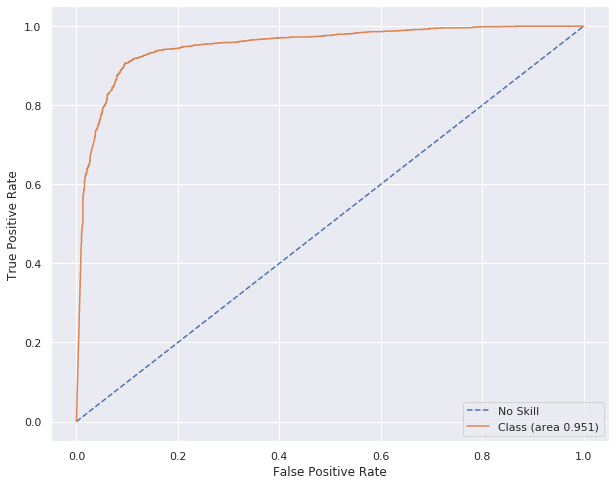



Model: f1-score=0.912 AUC=0.960




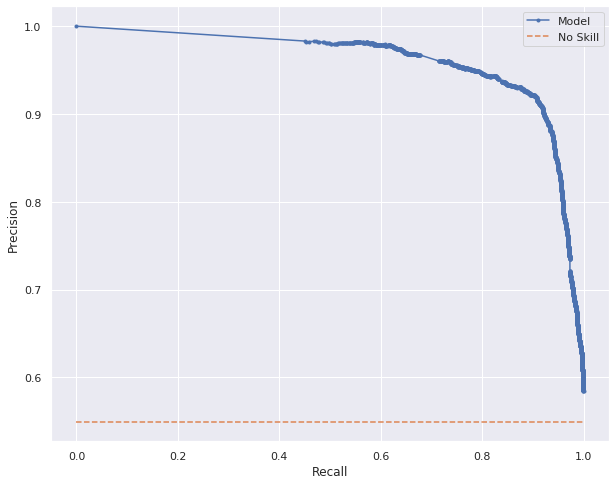


Cohen's kappa: 80.43% 

                 Predicted Negative  Predicted Positive
Actual Negative                1688                 209
Actual Positive                 199                2118

Confusion Matrix



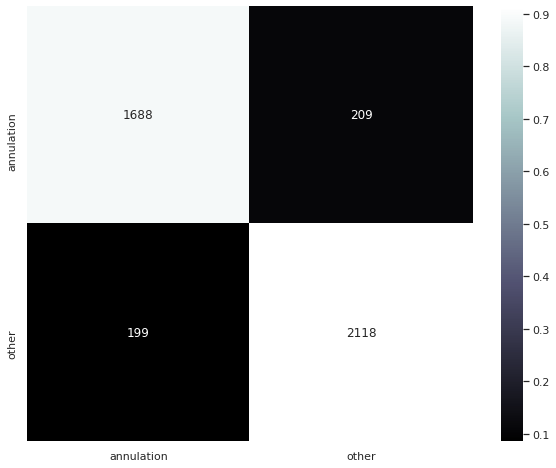

In [78]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 2</h2>

In [79]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [80]:
if deep_learning:
    model = deep_neural_networks_var2(word_index, pre_trained=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         15815400  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 15,819,177
Trainable params: 15,819,177
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 16:28:30 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43ab0b9d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.6964WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43d150950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 16:33:27 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe43d150950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 296s 702ms/step - loss: 0.6191 - accuracy: 0.6964 - val_loss: 0.5464 - val_accuracy: 0.8668
Epoch 2/1000
422/422 [==============================] - 267s 634ms/step - loss: 0.5448 - accuracy: 0.8811 - val_loss: 0.5320 - val_accuracy: 0.8831
Epoch 3/1000
422/422 [==============================] - 256s 606ms/step - loss: 0.5303 - accuracy: 0.9110 - val_loss: 0.5262 - val_accuracy: 0.9018
Epoch 4/1000
422/422 [==============================] - 250s 592ms/step - loss: 0.5238 - accuracy: 0.9241 - val_loss: 0.5251 - val_accuracy: 0.9027
Epoch 5/1000
422/422 [==============================] - 255s 605ms/step - loss: 0.5186 - accuracy: 0.9350 - val_los

In [82]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 0s 2ms/step - loss: 0.5358 - accuracy: 0.9015
[0.5358191132545471, 0.9015187621116638]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:21:24 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43bc8ed90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 89.66%


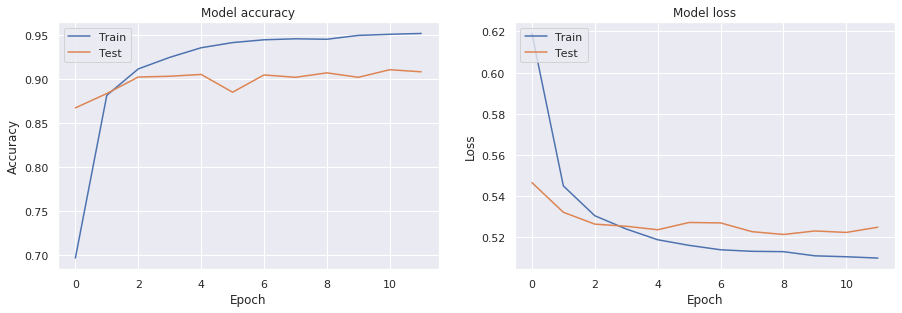

              precision    recall  f1-score   support

  annulation       0.91      0.87      0.89      1897
       other       0.90      0.93      0.91      2317

    accuracy                           0.90      4214
   macro avg       0.90      0.90      0.90      4214
weighted avg       0.90      0.90      0.90      4214


The balanced accuracy is : 89.86%


The Zero-one Loss is : 9.85%


Explained variance score: 0.604


ROC AUC=0.953 



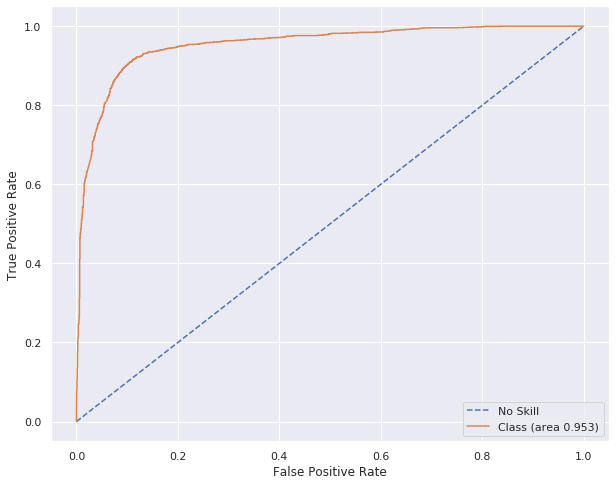



Model: f1-score=0.912 AUC=0.960




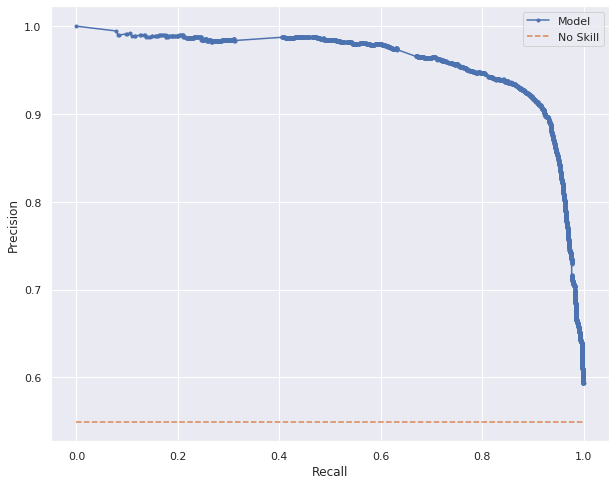


Cohen's kappa: 80.03% 

                 Predicted Negative  Predicted Positive
Actual Negative                1649                 248
Actual Positive                 167                2150

Confusion Matrix



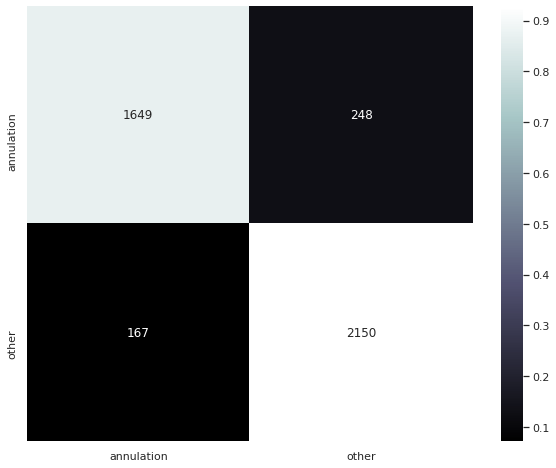

In [83]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurent Neural Network - RNN</h2>

---

In [84]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [85]:
if deep_learning:
    model = create_rnn_model(word_index, pre_trained=False )


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          7907700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          3640      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 40)          3240      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 40)          3240      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 41        
Total params: 7,921,101
Trainable params: 7,921,101
Non-trainable params: 0
____________________________________________

In [86]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:21:29 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe439df02f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7355WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440dfd488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:23:51 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440dfd488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 152s 361ms/step - loss: 0.6084 - accuracy: 0.7355 - val_loss: 0.5577 - val_accuracy: 0.8404
Epoch 2/1000
422/422 [==============================] - 149s 353ms/step - loss: 0.5590 - accuracy: 0.8479 - val_loss: 0.5440 - val_accuracy: 0.8535
Epoch 3/1000
422/422 [==============================] - 148s 351ms/step - loss: 0.5460 - accuracy: 0.8736 - val_loss: 0.5374 - val_accuracy: 0.8742
Epoch 4/1000
422/422 [==============================] - 146s 345ms/step - loss: 0.5372 - accuracy: 0.8953 - val_loss: 0.5393 - val_accuracy: 0.8831
Epoch 5/1000
422/422 [==============================] - 166s 394ms/step - loss: 0.5329 - accuracy: 0.9054 - val_los

In [87]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 11s 80ms/step - loss: 0.5414 - accuracy: 0.8901
[0.5414488315582275, 0.8901281356811523]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:51:34 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe4397d89d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 88.59%


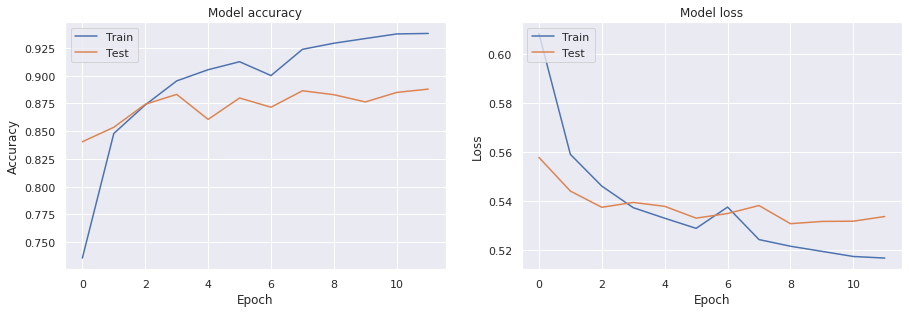

              precision    recall  f1-score   support

  annulation       0.90      0.86      0.88      1897
       other       0.89      0.92      0.90      2317

    accuracy                           0.89      4214
   macro avg       0.89      0.89      0.89      4214
weighted avg       0.89      0.89      0.89      4214


The balanced accuracy is : 88.7%


The Zero-one Loss is : 10.99%


Explained variance score: 0.558


ROC AUC=0.945 



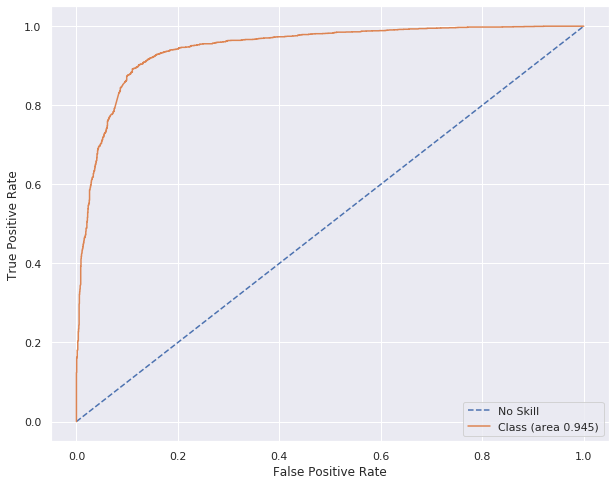



Model: f1-score=0.902 AUC=0.952




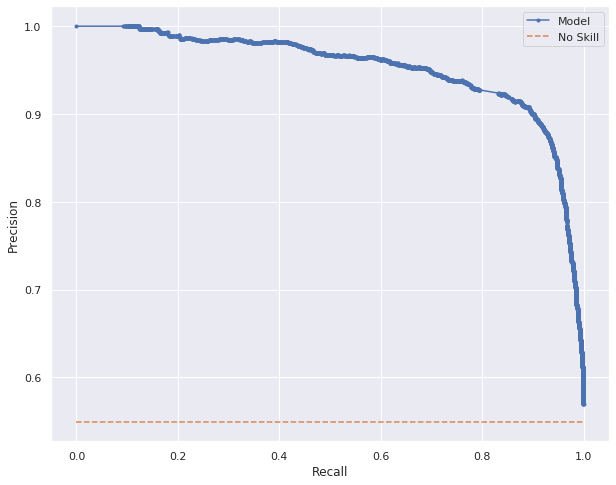


Cohen's kappa: 77.71% 

                 Predicted Negative  Predicted Positive
Actual Negative                1623                 274
Actual Positive                 189                2128

Confusion Matrix



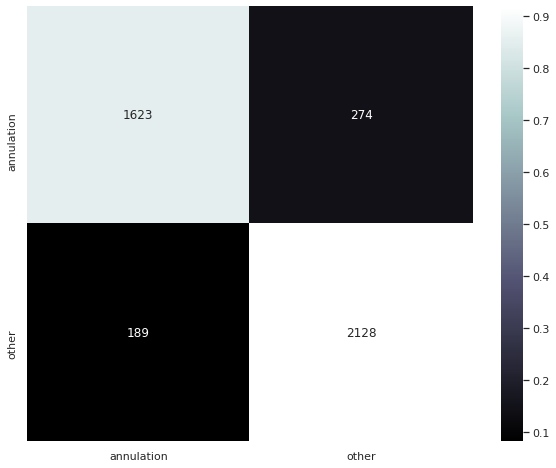

In [88]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Convolutional Neural Network</h2>

---

In [89]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [90]:
if deep_learning:
    model = create_conv_model(word_index, labels, pre_trained=False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          7907700   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         32128     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)         

In [91]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:53:19 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe4417bc510> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
421/422 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.5781WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440d36620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 17:53:52 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440d36620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 33s 79ms/step - loss: 0.6605 - accuracy: 0.5784 - val_loss: 0.6248 - val_accuracy: 0.6968
Epoch 2/50
422/422 [==============================] - 66s 156ms/step - loss: 0.5904 - accuracy: 0.8020 - val_loss: 0.5683 - val_accuracy: 0.8440
Epoch 3/50
422/422 [==============================] - 39s 93ms/step - loss: 0.5555 - accuracy: 0.8586 - val_loss: 0.5515 - val_accuracy: 0.8529
Epoch 4/50
422/422 [==============================] - 44s 104ms/step - loss: 0.5458 - accuracy: 0.8731 - val_loss: 0.5428 - val_accuracy: 0.8704
Epoch 5/50
422/422 [==============================] - 45s 107ms/step - loss: 0.5390 - accuracy: 0.8892 - val_loss: 0.5372 - val

In [92]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 2s 16ms/step - loss: 0.5384 - accuracy: 0.8851
[0.5383661985397339, 0.8851447701454163]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:05:41 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe440d36f28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 92.18%


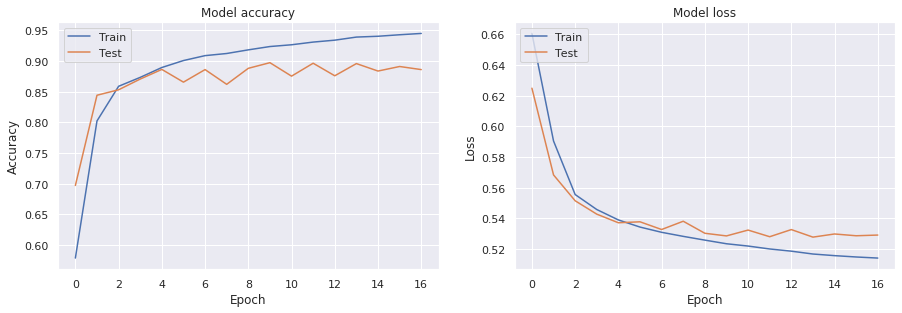

              precision    recall  f1-score   support

  annulation       0.85      0.91      0.88      1897
       other       0.92      0.86      0.89      2317

    accuracy                           0.89      4214
   macro avg       0.88      0.89      0.88      4214
weighted avg       0.89      0.89      0.89      4214


The balanced accuracy is : 88.74%


The Zero-one Loss is : 11.49%


Explained variance score: 0.541


ROC AUC=0.957 



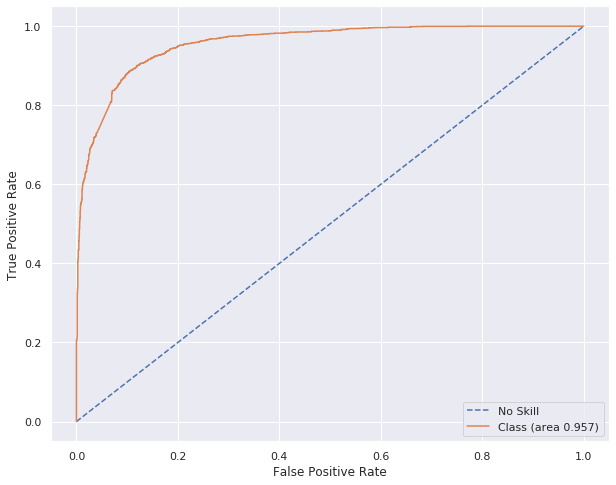



Model: f1-score=0.892 AUC=0.964




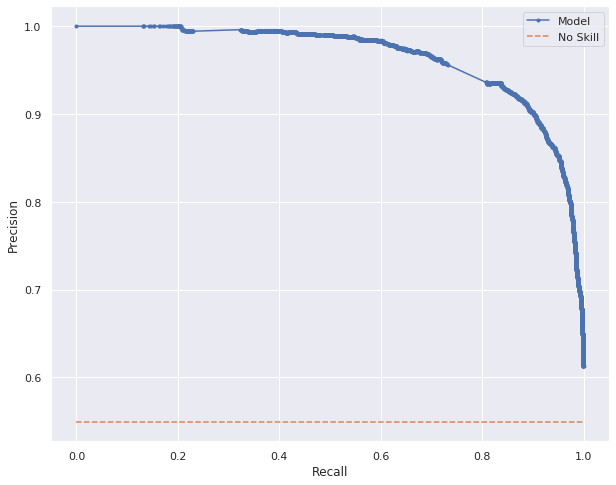


Cohen's kappa: 76.96% 

                 Predicted Negative  Predicted Positive
Actual Negative                1727                 170
Actual Positive                 314                2003

Confusion Matrix



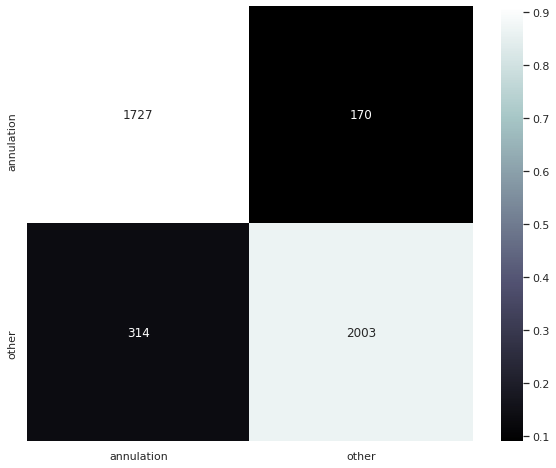

In [93]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Neural Network – LSTM</h2>

---

In [94]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [95]:
if deep_learning:
    model = create_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         15815400  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 15,832,457
Trainable params: 15,832,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence t

2020-05-12 18:06:02 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43ead4378> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.7305WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440b212f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:09:27 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440b212f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 207s 490ms/step - loss: 0.6088 - accuracy: 0.7305 - val_loss: 0.5678 - val_accuracy: 0.7944
Epoch 2/50
422/422 [==============================] - 205s 485ms/step - loss: 0.5497 - accuracy: 0.8650 - val_loss: 0.5374 - val_accuracy: 0.8775
Epoch 3/50
422/422 [==============================] - 200s 475ms/step - loss: 0.5510 - accuracy: 0.8778 - val_loss: 0.6277 - val_accuracy: 0.7517
Epoch 4/50
422/422 [==============================] - 220s 522ms/step - loss: 0.5885 - accuracy: 0.8061 - val_loss: 0.5821 - val_accuracy: 0.8205
Epoch 5/50
422/422 [==============================] - 222s 526ms/step - loss: 0.5830 - accuracy: 0.8299 - val_loss: 0.629

In [96]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 5s 36ms/step - loss: 0.6455 - accuracy: 0.7314
[0.6454887986183167, 0.7313716411590576]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:23:46 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe443ea6bf8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 68.44%


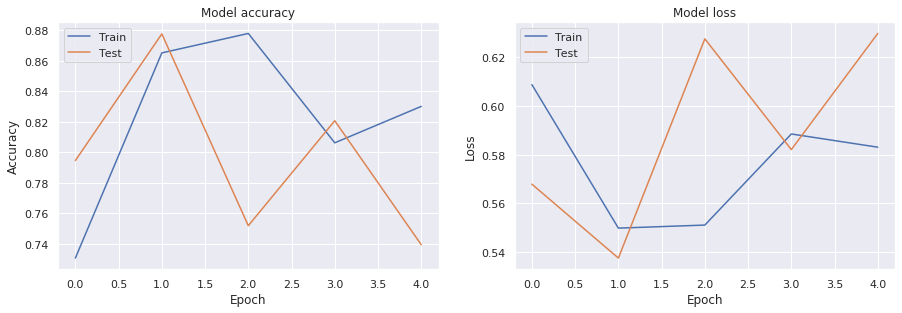

              precision    recall  f1-score   support

  annulation       0.88      0.47      0.61      1897
       other       0.68      0.95      0.80      2317

    accuracy                           0.73      4214
   macro avg       0.78      0.71      0.70      4214
weighted avg       0.77      0.73      0.71      4214


The balanced accuracy is : 70.73%


The Zero-one Loss is : 26.86%


Explained variance score: 0.097


ROC AUC=0.781 



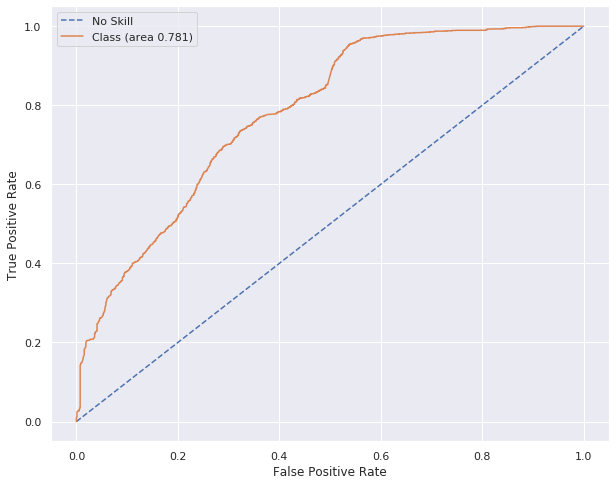



Model: f1-score=0.795 AUC=0.793




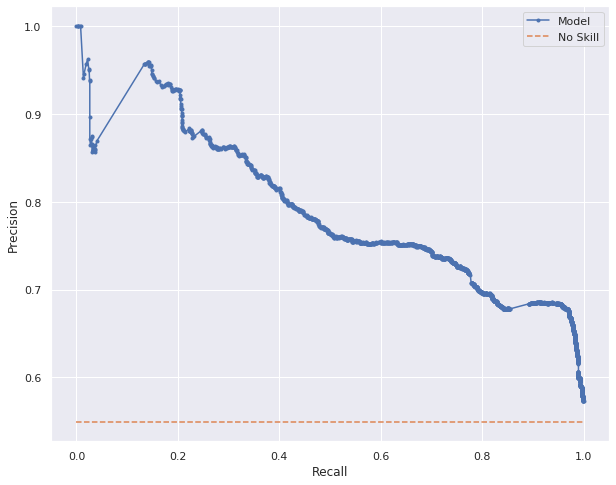


Cohen's kappa: 43.31% 

                 Predicted Negative  Predicted Positive
Actual Negative                 883                1014
Actual Positive                 118                2199

Confusion Matrix



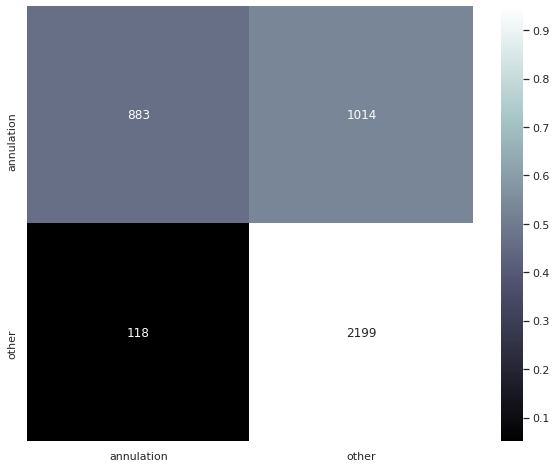

In [97]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>CNN – LSTM</h2>

---

In [98]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [99]:
if deep_learning:
    model = create_cnn_lstm_model(word_index, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         47446200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 47,730,029
Trainable params: 283,829
Non-trainable params: 47,446,200
____________________________________

2020-05-12 18:24:39 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43beffc80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6024WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440c3fd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:26:13 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe440c3fd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 98s 233ms/step - loss: 0.6483 - accuracy: 0.6024 - val_loss: 0.6021 - val_accuracy: 0.7206
Epoch 2/50
422/422 [==============================] - 92s 217ms/step - loss: 0.6303 - accuracy: 0.6483 - val_loss: 0.6158 - val_accuracy: 0.7164
Epoch 3/50
422/422 [==============================] - 93s 220ms/step - loss: 0.6260 - accuracy: 0.6956 - val_loss: 0.5847 - val_accuracy: 0.7535
Epoch 4/50
422/422 [==============================] - 95s 225ms/step - loss: 0.5936 - accuracy: 0.7556 - val_loss: 0.5775 - val_accuracy: 0.7570
Epoch 5/50
422/422 [==============================] - 94s 222ms/step - loss: 0.5834 - accuracy: 0.7778 - val_loss: 0.5780 - v

In [100]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 10s 75ms/step - loss: 0.6931 - accuracy: 0.4502
[0.6931463479995728, 0.45016610622406006]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:39:03 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe440b29a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 0.0%


/home/chris/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


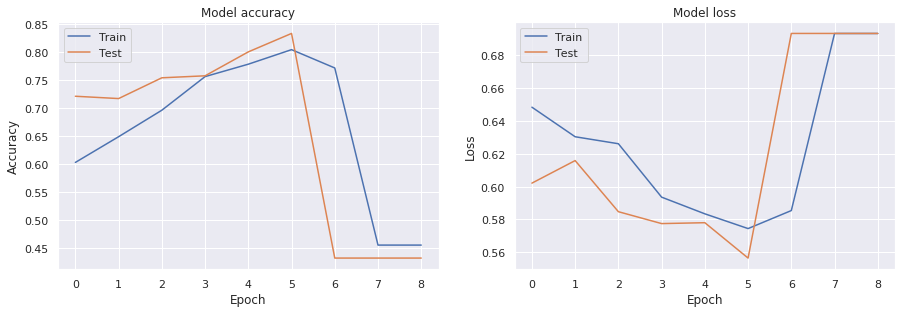

/home/chris/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  annulation       0.45      1.00      0.62      1897
       other       0.00      0.00      0.00      2317

    accuracy                           0.45      4214
   macro avg       0.23      0.50      0.31      4214
weighted avg       0.20      0.45      0.28      4214


The balanced accuracy is : 50.0%


The Zero-one Loss is : 54.98%


Explained variance score: 0.0


ROC AUC=0.625 



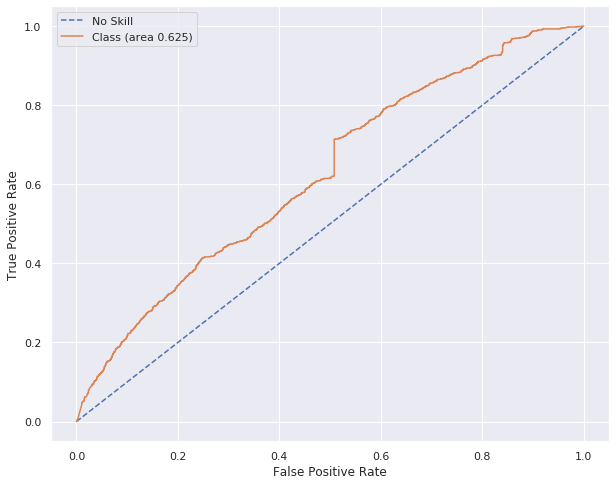



Model: f1-score=0.000 AUC=0.660




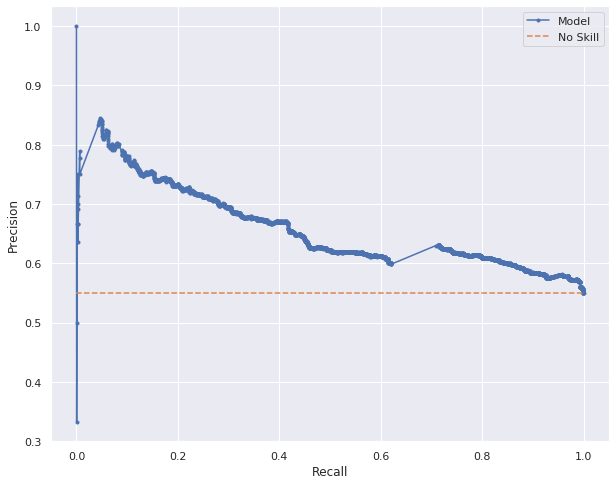


Cohen's kappa: 0.0% 

                 Predicted Negative  Predicted Positive
Actual Negative                1897                   0
Actual Positive                2317                   0

Confusion Matrix



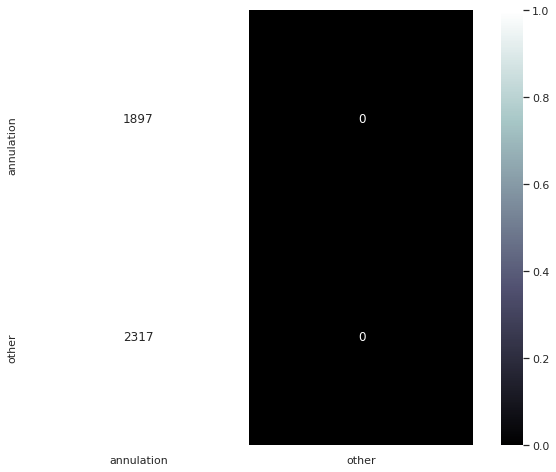

In [101]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>CNN – GRU</h2>

---

In [102]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(50),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [103]:
if deep_learning:
    model = create_cnn_gru_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 50)          7907700   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         32128     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, 50)                27000     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 7,966,879
Trainable params: 7,966,879
Non-trainable params: 0
____________________________________________

2020-05-12 18:40:32 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43ba60950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7653WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe441d321e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:41:48 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe441d321e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 76s 179ms/step - loss: 0.5888 - accuracy: 0.7653 - val_loss: 0.5539 - val_accuracy: 0.8202
Epoch 2/50
422/422 [==============================] - 74s 175ms/step - loss: 0.5586 - accuracy: 0.8463 - val_loss: 0.5827 - val_accuracy: 0.7484
Epoch 3/50
422/422 [==============================] - 74s 176ms/step - loss: 0.5509 - accuracy: 0.8569 - val_loss: 0.5482 - val_accuracy: 0.8490
Epoch 4/50
422/422 [==============================] - 83s 196ms/step - loss: 0.5353 - accuracy: 0.8949 - val_loss: 0.5362 - val_accuracy: 0.8846
Epoch 5/50
422/422 [==============================] - 69s 163ms/step - loss: 0.5309 - accuracy: 0.9038 - val_loss: 0.5446 - v

In [104]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 3s 23ms/step - loss: 0.5535 - accuracy: 0.8671
[0.5534568428993225, 0.8671096563339233]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:53:27 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43b52d620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 86.38%


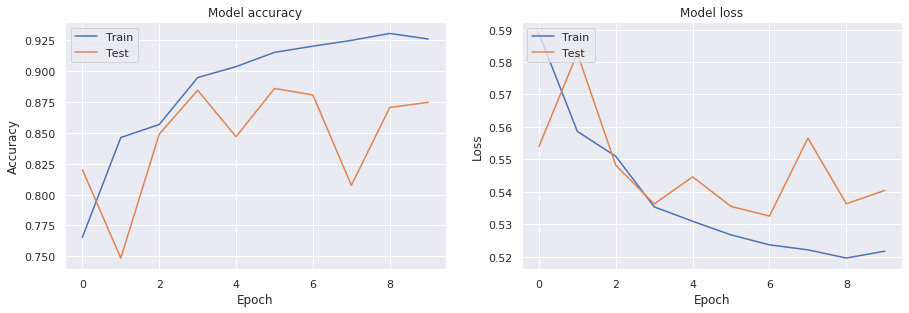

              precision    recall  f1-score   support

  annulation       0.87      0.83      0.85      1897
       other       0.86      0.90      0.88      2317

    accuracy                           0.87      4214
   macro avg       0.87      0.86      0.87      4214
weighted avg       0.87      0.87      0.87      4214


The balanced accuracy is : 86.34%


The Zero-one Loss is : 13.29%


Explained variance score: 0.465


ROC AUC=0.920 



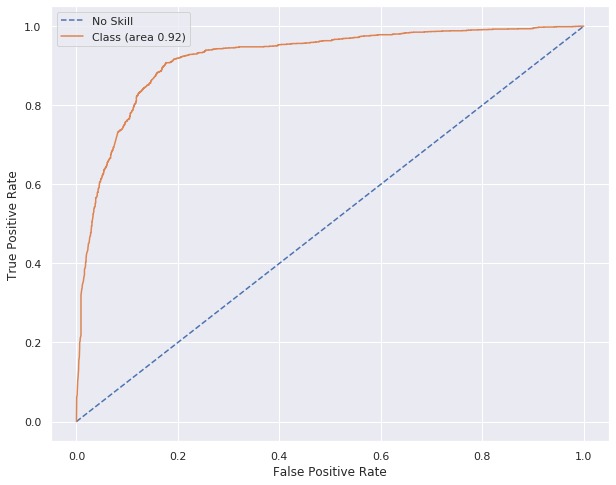



Model: f1-score=0.882 AUC=0.928




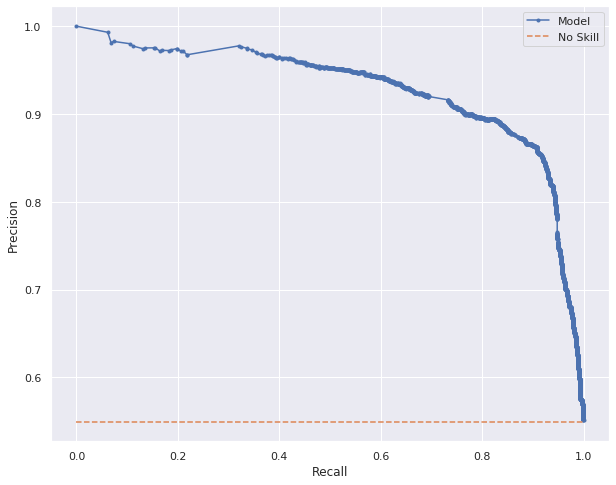


Cohen's kappa: 73.03% 

                 Predicted Negative  Predicted Positive
Actual Negative                1568                 329
Actual Positive                 231                2086

Confusion Matrix



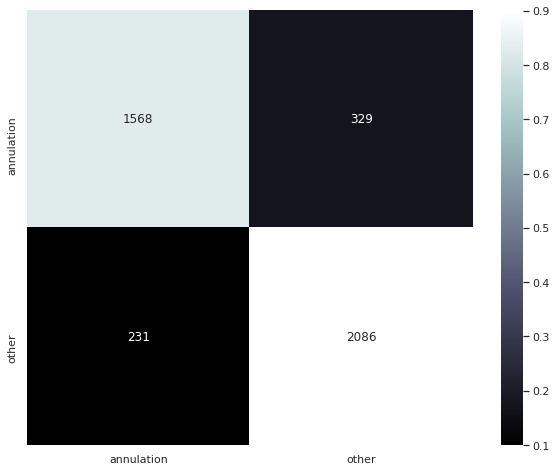

In [105]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Neural Network – GRU</h2>

---

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [106]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [107]:
if deep_learning:
    model = create_gru_model(word_index, pre_trained=False )


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 50)          7907700   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                8064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 7,915,797
Trainable params: 7,915,797
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence thi

2020-05-12 18:53:55 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43420d7b8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.7418WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe436fad1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 18:55:42 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe436fad1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 109s 259ms/step - loss: 0.6017 - accuracy: 0.7418 - val_loss: 0.5867 - val_accuracy: 0.7333
Epoch 2/50
422/422 [==============================] - 105s 248ms/step - loss: 0.6423 - accuracy: 0.5997 - val_loss: 0.5685 - val_accuracy: 0.7912
Epoch 3/50
422/422 [==============================] - 101s 240ms/step - loss: 0.5587 - accuracy: 0.8394 - val_loss: 0.5609 - val_accuracy: 0.8027
Epoch 4/50
422/422 [==============================] - 103s 245ms/step - loss: 0.5379 - accuracy: 0.8873 - val_loss: 0.5527 - val_accuracy: 0.8392
Epoch 5/50
422/422 [==============================] - 106s 252ms/step - loss: 0.5298 - accuracy: 0.9063 - val_loss: 0.551

In [108]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 4s 33ms/step - loss: 0.6096 - accuracy: 0.6837
[0.6095783710479736, 0.6836734414100647]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:11:57 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe42e615ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 92.34%


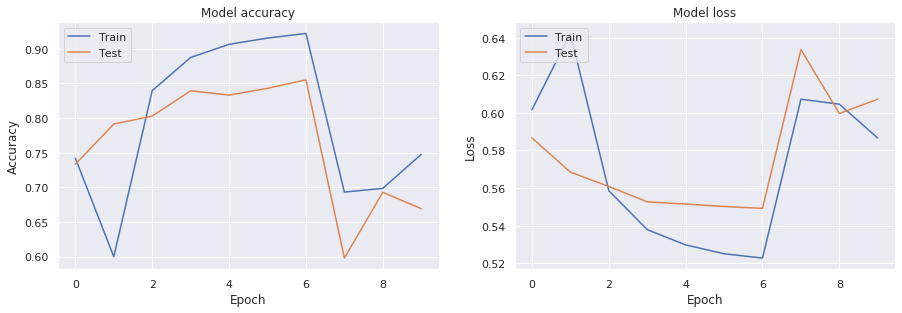

              precision    recall  f1-score   support

  annulation       0.59      0.95      0.73      1897
       other       0.92      0.46      0.62      2317

    accuracy                           0.68      4214
   macro avg       0.76      0.71      0.67      4214
weighted avg       0.77      0.68      0.67      4214


The balanced accuracy is : 70.81%


The Zero-one Loss is : 31.63%


Explained variance score: 0.026


ROC AUC=0.830 



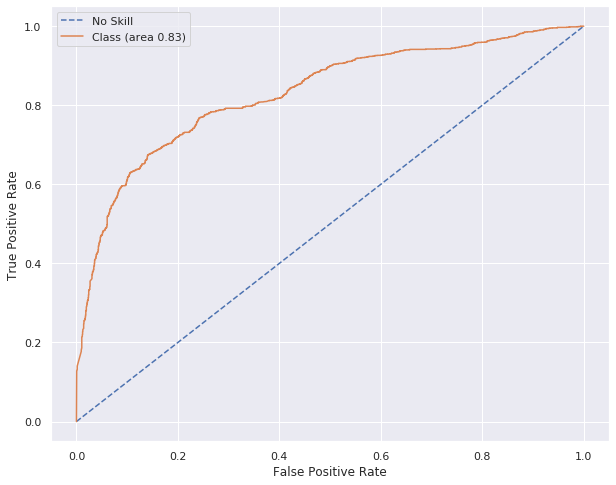



Model: f1-score=0.617 AUC=0.867




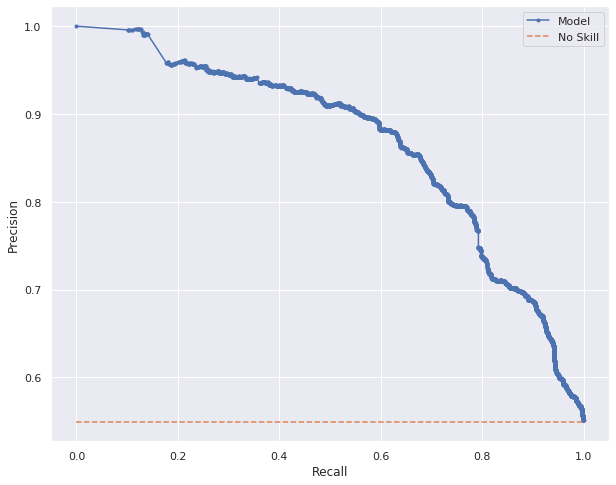


Cohen's kappa: 39.44% 

                 Predicted Negative  Predicted Positive
Actual Negative                1808                  89
Actual Positive                1244                1073

Confusion Matrix



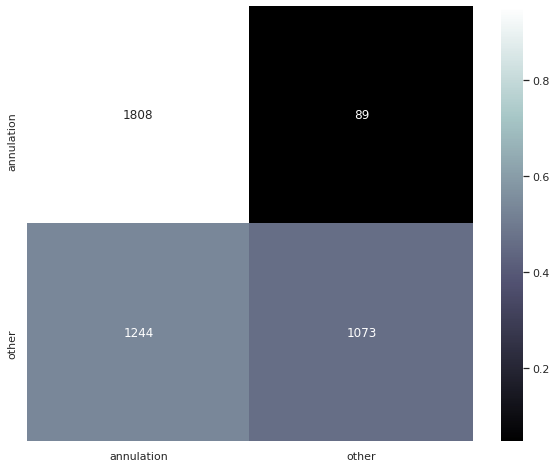

In [109]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional RNN</h2>

---

In [110]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [111]:
if deep_learning:
    model = create_bidirec_rnn_model(word_index)
    
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 50)          7907700   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          5312      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                6208      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 7,919,285
Trainable params: 7,919,285
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on L

2020-05-12 19:12:39 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe44077e9d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.7720WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe441231c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:14:42 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe441231c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 127s 300ms/step - loss: 0.5950 - accuracy: 0.7720 - val_loss: 0.5588 - val_accuracy: 0.8262
Epoch 2/50
422/422 [==============================] - 123s 291ms/step - loss: 0.5505 - accuracy: 0.8666 - val_loss: 0.5461 - val_accuracy: 0.8517
Epoch 3/50
422/422 [==============================] - 123s 291ms/step - loss: 0.5287 - accuracy: 0.9138 - val_loss: 0.5400 - val_accuracy: 0.8624
Epoch 4/50
422/422 [==============================] - 127s 301ms/step - loss: 0.5185 - accuracy: 0.9330 - val_loss: 0.5473 - val_accuracy: 0.8490
Epoch 5/50
422/422 [==============================] - 125s 297ms/step - loss: 0.5122 - accuracy: 0.9458 - val_loss: 0.571

In [112]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 8s 61ms/step - loss: 0.5582 - accuracy: 0.8436
[0.5582343935966492, 0.8436165452003479]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:31:39 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43e535c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 87.61%


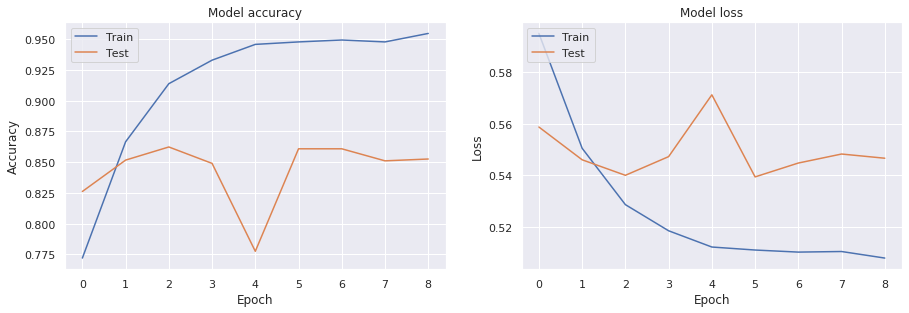

              precision    recall  f1-score   support

  annulation       0.81      0.86      0.83      1897
       other       0.88      0.83      0.85      2317

    accuracy                           0.84      4214
   macro avg       0.84      0.84      0.84      4214
weighted avg       0.85      0.84      0.84      4214


The balanced accuracy is : 84.47%


The Zero-one Loss is : 15.64%


Explained variance score: 0.371


ROC AUC=0.909 



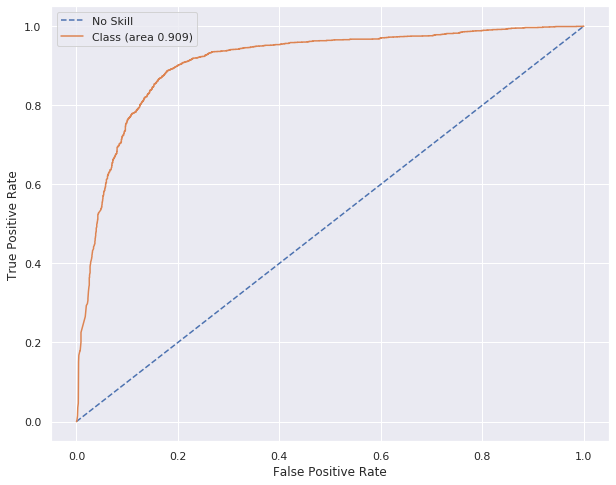



Model: f1-score=0.854 AUC=0.909




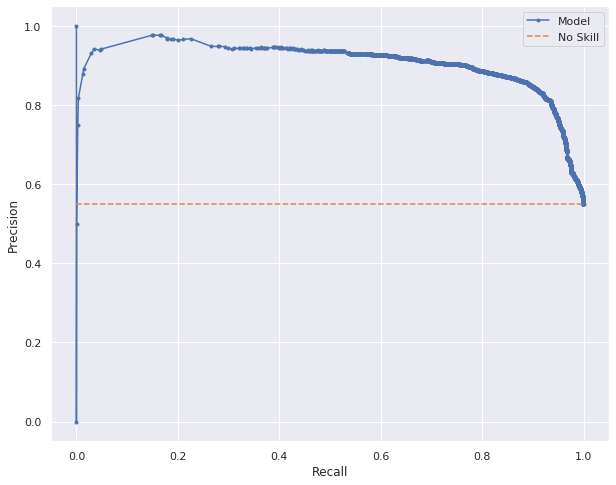


Cohen's kappa: 68.58% 

                 Predicted Negative  Predicted Positive
Actual Negative                1624                 273
Actual Positive                 386                1931

Confusion Matrix



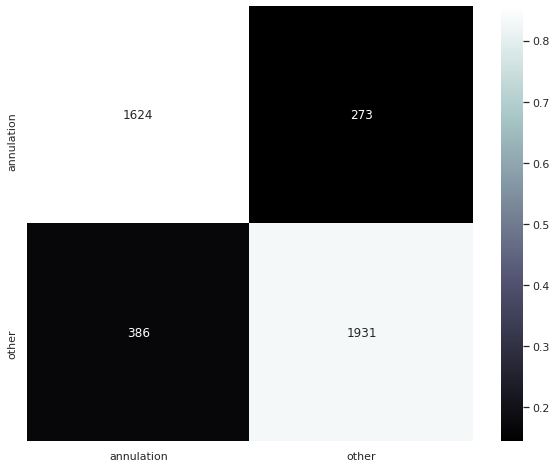

In [113]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional LSTM</h2>

---

In [114]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [115]:
if deep_learning:
    model = create_bidirec_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          7907700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                21248     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 7,929,013
Trainable params: 7,929,013
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence th

2020-05-12 19:33:07 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe42e524158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.7526WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe438b8df28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:35:00 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe438b8df28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 116s 274ms/step - loss: 0.5980 - accuracy: 0.7526 - val_loss: 0.5513 - val_accuracy: 0.8425
Epoch 2/50
422/422 [==============================] - 120s 284ms/step - loss: 0.5551 - accuracy: 0.8495 - val_loss: 0.5461 - val_accuracy: 0.8487
Epoch 3/50
422/422 [==============================] - 112s 266ms/step - loss: 0.5519 - accuracy: 0.8522 - val_loss: 0.5533 - val_accuracy: 0.8294
Epoch 4/50
422/422 [==============================] - 112s 265ms/step - loss: 0.5451 - accuracy: 0.8816 - val_loss: 0.5427 - val_accuracy: 0.8585
Epoch 5/50
422/422 [==============================] - 111s 263ms/step - loss: 0.5319 - accuracy: 0.9076 - val_loss: 0.540

In [116]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 6s 43ms/step - loss: 0.5445 - accuracy: 0.8752
[0.5445442199707031, 0.8751779794692993]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:56:25 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43f826d08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 89.54%


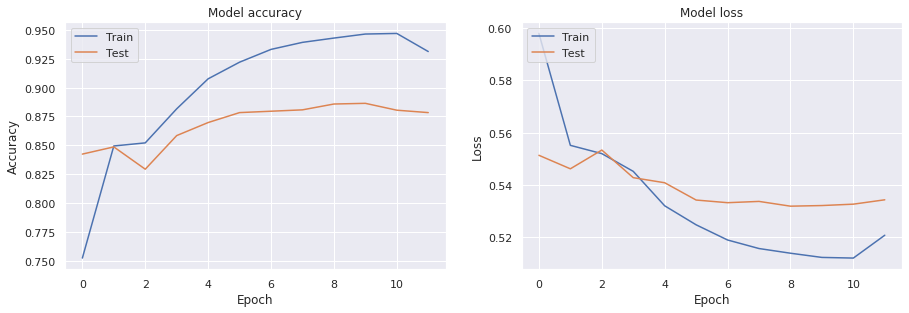

              precision    recall  f1-score   support

  annulation       0.85      0.88      0.86      1897
       other       0.90      0.88      0.89      2317

    accuracy                           0.88      4214
   macro avg       0.87      0.88      0.87      4214
weighted avg       0.88      0.88      0.88      4214


The balanced accuracy is : 87.52%


The Zero-one Loss is : 12.48%


Explained variance score: 0.496


ROC AUC=0.931 



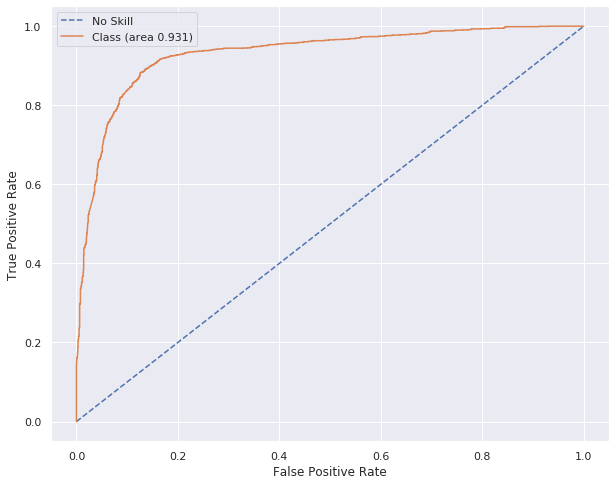



Model: f1-score=0.885 AUC=0.942




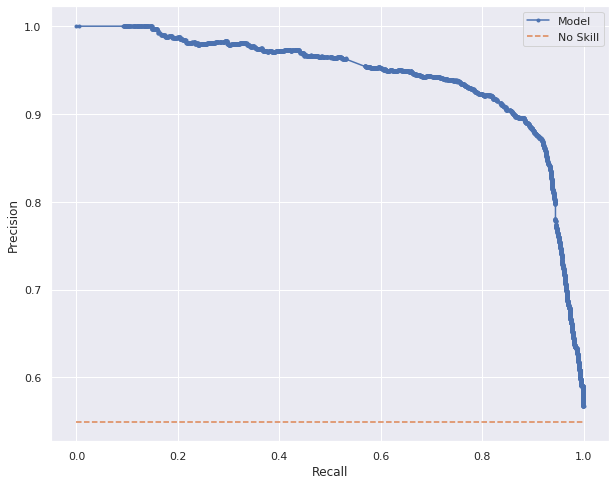


Cohen's kappa: 74.85% 

                 Predicted Negative  Predicted Positive
Actual Negative                1660                 237
Actual Positive                 289                2028

Confusion Matrix



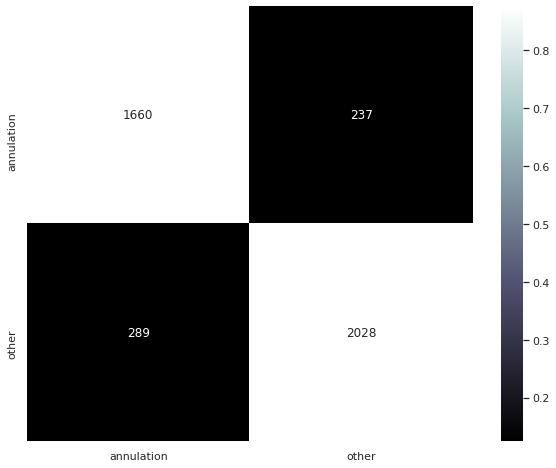

In [117]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional GRU</h2>

---

In [118]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [119]:
if deep_learning:
    model = create_bidirec_gru_model(word_index, pre_trained=False)#, embedding_matrix=embedding_matrix, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 50)          7907700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                16128     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 7,923,893
Trainable params: 7,923,893
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence th

2020-05-12 19:57:18 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe428997bf8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7313WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe4357d2048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 19:59:16 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe4357d2048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 118s 280ms/step - loss: 0.6038 - accuracy: 0.7313 - val_loss: 0.5603 - val_accuracy: 0.7995
Epoch 2/50
422/422 [==============================] - 117s 276ms/step - loss: 0.5584 - accuracy: 0.8407 - val_loss: 0.5535 - val_accuracy: 0.8303
Epoch 3/50
422/422 [==============================] - 115s 273ms/step - loss: 0.5344 - accuracy: 0.8999 - val_loss: 0.5459 - val_accuracy: 0.8472
Epoch 4/50
422/422 [==============================] - 122s 290ms/step - loss: 0.5266 - accuracy: 0.9175 - val_loss: 0.5429 - val_accuracy: 0.8650
Epoch 5/50
422/422 [==============================] - 116s 275ms/step - loss: 0.5229 - accuracy: 0.9229 - val_loss: 0.547

In [120]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 5s 41ms/step - loss: 0.5553 - accuracy: 0.8417
[0.5552560091018677, 0.8417180776596069]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 20:11:12 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe443ea6ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 90.2%


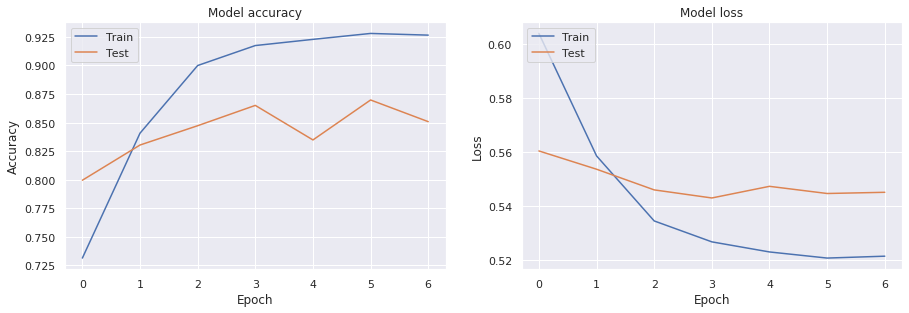

              precision    recall  f1-score   support

  annulation       0.78      0.89      0.84      1897
       other       0.90      0.80      0.85      2317

    accuracy                           0.84      4214
   macro avg       0.84      0.85      0.84      4214
weighted avg       0.85      0.84      0.84      4214


The balanced accuracy is : 84.65%


The Zero-one Loss is : 15.83%


Explained variance score: 0.376


ROC AUC=0.909 



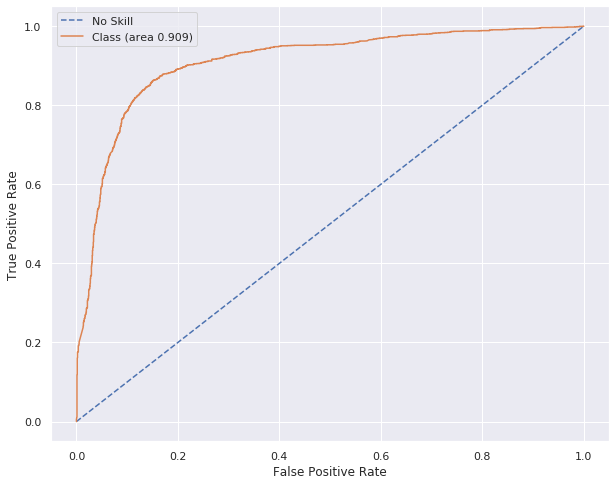



Model: f1-score=0.847 AUC=0.916




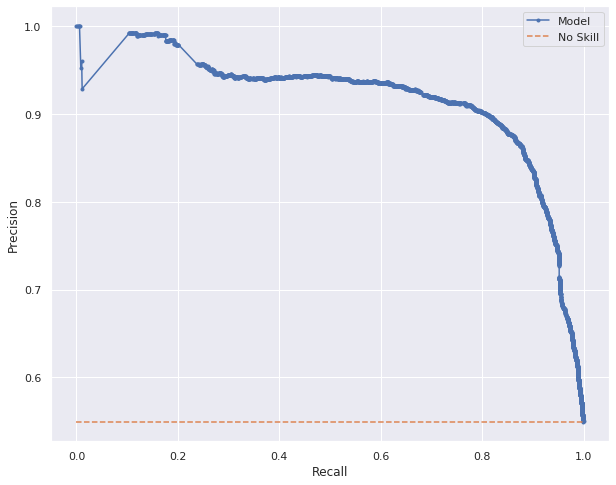


Cohen's kappa: 68.43% 

                 Predicted Negative  Predicted Positive
Actual Negative                1696                 201
Actual Positive                 466                1851

Confusion Matrix



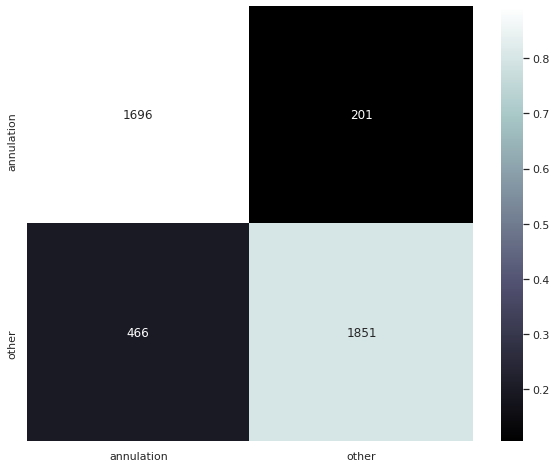

In [121]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convolutional Neural Network</h2>

---

In [122]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [123]:
if deep_learning:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         15815400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         121200    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)              

2020-05-12 20:12:01 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe43bb10400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.6517WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe2183768c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 20:18:33 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe2183768c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 401s 951ms/step - loss: 0.6779 - accuracy: 0.6517 - val_loss: 0.7080 - val_accuracy: 0.6218
Epoch 2/50
422/422 [==============================] - 423s 1s/step - loss: 0.7298 - accuracy: 0.6025 - val_loss: 0.7080 - val_accuracy: 0.6218
Epoch 3/50
422/422 [==============================] - 413s 978ms/step - loss: 0.7293 - accuracy: 0.6031 - val_loss: 0.7080 - val_accuracy: 0.6218
Epoch 4/50
422/422 [==============================] - 428s 1s/step - loss: 0.7298 - accuracy: 0.6033 - val_loss: 0.7080 - val_accuracy: 0.6218


In [124]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

132/132 [==============================] - 14s 106ms/step - loss: 0.7265 - accuracy: 0.6061
[0.7264993190765381, 0.6060749888420105]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 20:40:08 WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fe43d8f6c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

The precision of the model is 58.42%


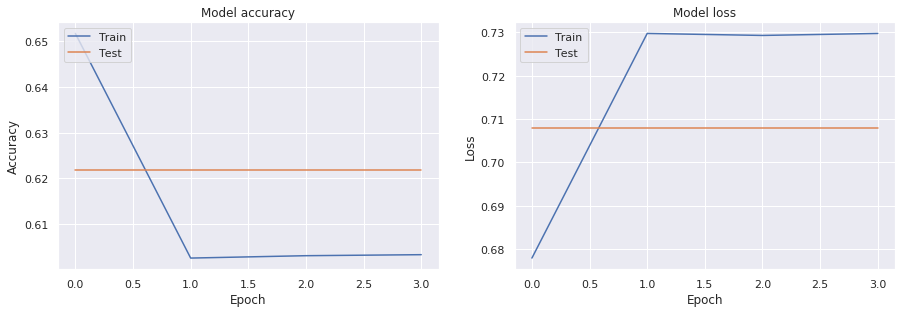

              precision    recall  f1-score   support

  annulation       0.88      0.14      0.25      1897
       other       0.58      0.98      0.73      2317

    accuracy                           0.61      4214
   macro avg       0.73      0.56      0.49      4214
weighted avg       0.72      0.61      0.52      4214


The balanced accuracy is : 56.43%


The Zero-one Loss is : 39.39%


Explained variance score: -0.021


ROC AUC=0.565 



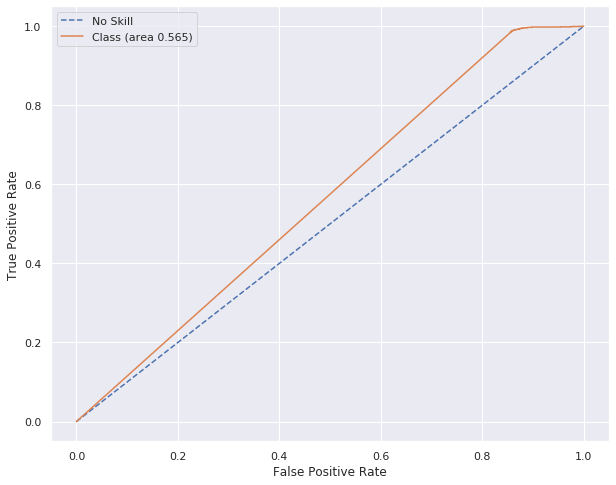



Model: f1-score=0.733 AUC=0.789




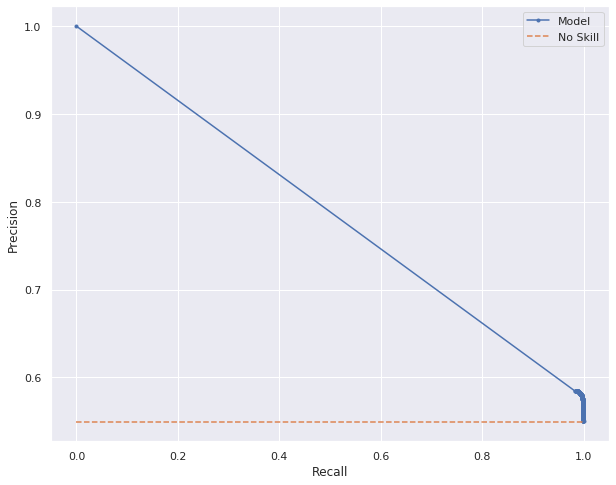


Cohen's kappa: 13.91% 

                 Predicted Negative  Predicted Positive
Actual Negative                 275                1622
Actual Positive                  38                2279

Confusion Matrix



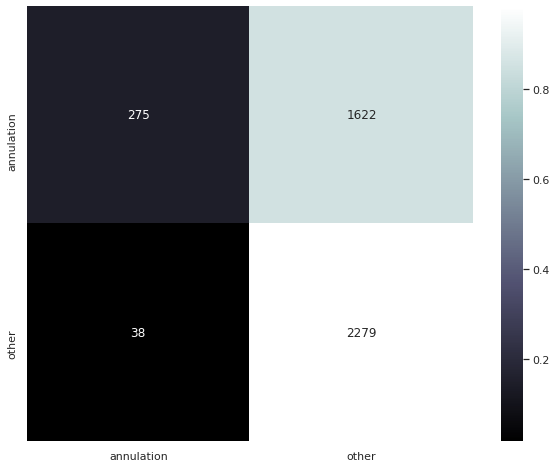

In [125]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convolutional Neural Network variation 1</h2>

---

In [126]:
def create_rcnn_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [127]:
if deep_learning:
    model = create_rcnn_var1(word_index, pre_trained = False)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         15815400  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)              

2020-05-12 20:42:14 WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe4428328c8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.5300WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe42e50de18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2020-05-12 20:50:47 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe42e50de18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
422/422 [==============================] - 520s 1s/step - loss: 0.6675 - accuracy: 0.5300 - val_loss: 0.6625 - val_accuracy: 0.5177
Epoch 2/50
422/422 [==============================] - 474s 1s/step - loss: 0.6659 - accuracy: 0.5329 - val_loss: 0.6625 - val_accuracy: 0.5177
Epoch 3/50
422/422 [==============================] - 458s 1s/step - loss: 0.6234 - accuracy: 0.6753 - val_loss: 0.5863 - val_accuracy: 0.7395
Epoch 4/50
352/422 [========================>.....] - ETA: 1:18 - loss: 0.5755 - accuracy: 0.8075

KeyboardInterrupt: 

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convulational Neural Network variation 2</h2>

---

In [ ]:
def create_rcnn_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn_var2(word_index,  pre_trained = False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convulational Neural Network variation 3</h2>

---

In [ ]:
def create_rcnn_var3(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(50,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(25,return_sequences=True)),
    keras.layers.Convolution1D(50, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn_var3(word_index,  pre_trained = True)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

In [ ]:
if deep_learning:
    Metric.func_metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Transformers</h2>

huggingface

In [ ]:
if transformers_model:
    camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
# Create a ClassificationModel
if transformers_model:
    model = ClassificationModel('camembert', 'camembert-base', use_cuda=False,  num_labels=3)

In [ ]:
# Create a TransformerModel with modified attributes
#if transformers_model:
#    model = TransformerModel('roberta', 'roberta-base', num_labels=4, args={'learning_rate':1e-5, 'num_train_epochs': 2, 'reprocess_input_data': True, 'overwrite_output_dir': True})


In [ ]:
if transformers_model:
    encoder = preprocessing.LabelEncoder()
    #train_y = encoder.fit_transform(train_y)
    df.label = encoder.fit_transform(df.label)
    num = int(df.shape[0]*0.8)
    x_train = df[[TEXT, LABEL]].iloc[ :num]
    x_test = df[[TEXT, LABEL]].iloc[num:]

In [ ]:
if transformers_model:
    x_train.rename(columns={TEXT:"text"}, inplace=True)
    x_test.rename(columns={TEXT:"text"}, inplace=True)

In [ ]:
# Train the model
if transformers_model:
    model.train_model(x_train, reprocess_input_data=True)

In [ ]:
if transformers_model:
    result, model_outputs, wrong_predictions = model.eval_model(x_test)

In [ ]:
if transformers_model:
    print(result)

In [ ]:
def func_precision_recall(result):
    
    tn, fp, fn, tp = result["tn"], result["fp"], result["fn"], result["tp"]
    
    print('''     Predicted       Predicted  
                 NO               YES
        Real   TN={}          FP={}
        NO     
        Real   FN={}           TP={}
        YES       '''.format(tn, fp, fn, tp))
    print('''
                  TP                     
    Precision = _______ = {}%    
                 TP+FP       


               TP
    Recall = ______  = {}%
              FN+TP           '''.format(round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)))
    return round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)


In [ ]:
if transformers_model:
    func_precision_recall(result)

<h2>Pre-Trained transformers models</h2>

bert / roberta / albert / camembert / ulmfit / gpt-2 

<h3>Reinforcement Learning</h3>

<h3>Autokeras</h3>

<h2>Knowledge Graphs</h2>